In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [47]:
def load_data():
    path = Path('data')
    dataframe = []
    for folder in path.iterdir():
        activity = str(folder.name)
        data = pd.concat((pd.read_csv(file) for file in folder.iterdir()), ignore_index=True)
        data['activity'] = activity
        dataframe.append(data)
    dataframe = pd.concat(dataframe)
    dataframe.to_pickle('all_data.pkl')
    
if not Path('all_data.pkl').is_file():
    load_data()
df = pd.read_pickle('all_data.pkl')

In [48]:
df.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,1.000776,4.616021,8.576031,idle
1,0.718261,4.209007,8.446744,idle
2,-0.909797,-0.282516,9.203311,idle
3,5.099650,0.148441,8.418014,idle
4,1.762132,-0.162806,9.251195,idle


In [49]:
df.describe()

,accelerometer_X,accelerometer_Y,accelerometer_Z
count,193860.000000,193860.000000,193860.000000
mean,1.923550,1.598343,1.804896
std,8.404867,12.474041,7.191590
min,-39.188293,-39.188293,-39.188293
25%,-2.494758,-8.327033,-2.494758
50%,0.248997,-0.009577,0.905008
75%,4.668694,8.671799,7.187394
max,39.188293,39.188293,39.188293


In [50]:
activities = df['activity'].unique()
attributes = df.columns.to_list()
attributes.remove('activity')
print(activities, attributes)

['idle' 'running' 'stairs' 'walking'] ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']


In [51]:
def heatmap_plot(model_name, conf_mat):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=activities, yticklabels=activities)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

In [52]:
X = df.drop('activity', axis = 1)
y = df['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.4)

In [53]:
%%time
svc = SVC().fit(X_train, y_train)
y_test_predicted_svc = svc.predict(X_test)

CPU times: total: 1min 33s
Wall time: 4min 40s


In [54]:
%%time
rfc = RandomForestClassifier(n_estimators=30).fit(X_train, y_train)
y_test_predicted_rfc = rfc.predict(X_test)

CPU times: total: 1.05 s
Wall time: 2.69 s


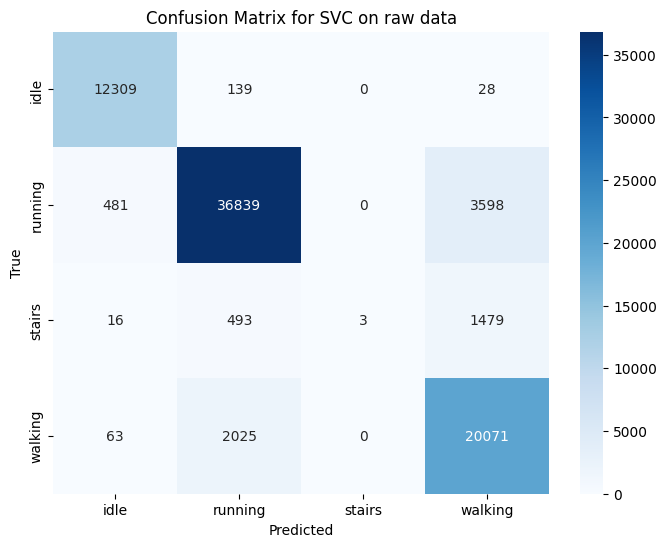

              precision    recall  f1-score   support

        idle       0.96      0.99      0.97     12476
     running       0.93      0.90      0.92     40918
      stairs       1.00      0.00      0.00      1991
     walking       0.80      0.91      0.85     22159

    accuracy                           0.89     77544
   macro avg       0.92      0.70      0.68     77544
weighted avg       0.90      0.89      0.88     77544



In [55]:
svc_confusion_matrix = confusion_matrix(y_test, y_test_predicted_svc)
svc_classification_report = classification_report(y_test, y_test_predicted_svc)
heatmap_plot("SVC on raw data", svc_confusion_matrix)
print(svc_classification_report)

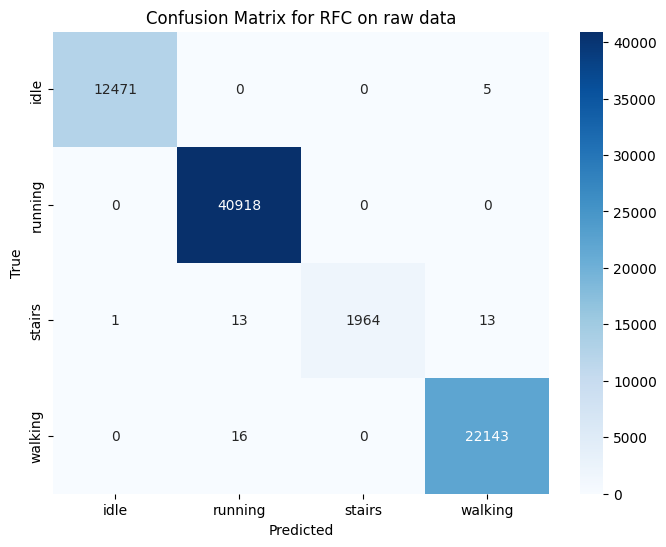

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00     12476
     running       1.00      1.00      1.00     40918
      stairs       1.00      0.99      0.99      1991
     walking       1.00      1.00      1.00     22159

    accuracy                           1.00     77544
   macro avg       1.00      1.00      1.00     77544
weighted avg       1.00      1.00      1.00     77544



In [56]:
rfc_confusion_matrix = confusion_matrix(y_test, y_test_predicted_rfc)
rfc_classification_report = classification_report(y_test, y_test_predicted_rfc)
heatmap_plot("RFC on raw data", rfc_confusion_matrix)
print(rfc_classification_report)

In [57]:
def entropy(data):
    hist, bins = np.histogram(data, bins='auto')
    probs = hist / len(data)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

def interquartile_range(data):
    return data.quantile(0.75) - data.quantile(0.25)

def mean_of_absolute_deviation(data):
    return abs(data - data.mean()).mean()

def root_mean_square_error(data):
    mean = np.mean(data)
    squared_errors = [(x - mean) ** 2 for x in data]
    return np.sqrt(np.mean(squared_errors))

def idxmin(data):
    return np.argmin(data)


attr_agg_funcs = {
    'accelerometer_X': ['max', 'min', entropy, interquartile_range],
    'accelerometer_Y': ['max', idxmin, mean_of_absolute_deviation, 'median', 'skew','std', root_mean_square_error],
    'accelerometer_Z': ['skew']
}

time_domain_features = df.groupby(["activity", df.index// 50]).agg(attr_agg_funcs) 
time_domain_features.reset_index(level=0, inplace=True)
time_domain_features.head()

activity accelerometer_X                                          \
                       max       min   entropy interquartile_range   
0     idle        5.099650 -0.909797  3.109675            0.061052   
1     idle        0.488417 -0.191536  2.868059            0.040701   
2     idle        0.560243  0.268151  2.622683            0.047885   
3     idle        0.560243  0.268151  2.711231            0.047885   
4     idle        0.560243  0.268151  2.717922            0.043096   

  accelerometer_Y                                                        \
              max idxmin mean_of_absolute_deviation    median      skew   
0        4.616021      2                   0.353354 -0.129287  4.814225   
1        0.244209      7                   0.143269  0.210690 -0.570181   
2        0.086191     18                   0.036852 -0.019154 -1.086890   
3        0.086191     24                   0.032806 -0.019154 -0.867348   
4        0.086191      2                   0.032201 -0.026336 -1.206709   

                                   accelerometer_Z  
        std root_mean_square_error            skew  
0  0.903715               0.894632       -3.279397  
1  0.153039               0.151501       -0.219022  
2  0.055049               0.054495        0.490050  
3  0.047460               0.046983        0.581889  
4  0.051055               0.050542        0.465670

In [58]:
X = time_domain_features[attributes]
y = time_domain_features['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [59]:
%%time
svc = SVC(kernel="linear").fit(X_train, y_train)
y_test_predicted_svc = svc.predict(X_test)

CPU times: total: 0 ns
Wall time: 34 ms


In [60]:
%%time
rfc = RandomForestClassifier(n_estimators=30).fit(X_train, y_train)
y_test_predicted_rfc = rfc.predict(X_test)

CPU times: total: 31.2 ms
Wall time: 82 ms


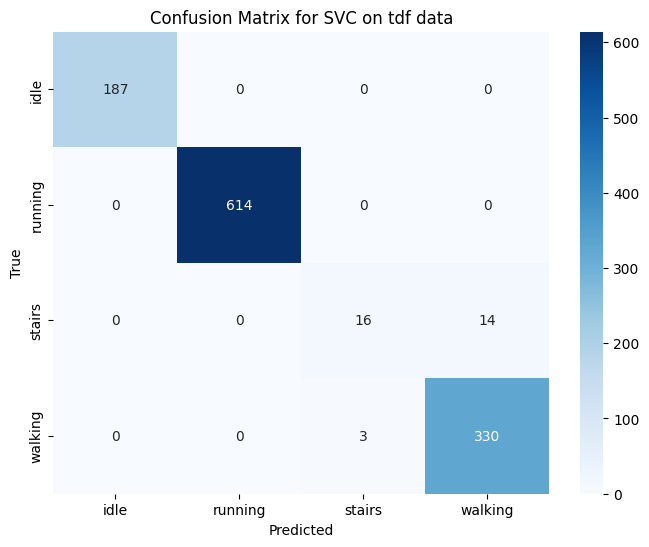

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       187
     running       1.00      1.00      1.00       614
      stairs       0.84      0.53      0.65        30
     walking       0.96      0.99      0.97       333

    accuracy                           0.99      1164
   macro avg       0.95      0.88      0.91      1164
weighted avg       0.98      0.99      0.98      1164



In [61]:
svc_confusion_matrix = confusion_matrix(y_test, y_test_predicted_svc)
svc_classification_report = classification_report(y_test, y_test_predicted_svc)
heatmap_plot("SVC on tdf data", svc_confusion_matrix)
print(svc_classification_report)

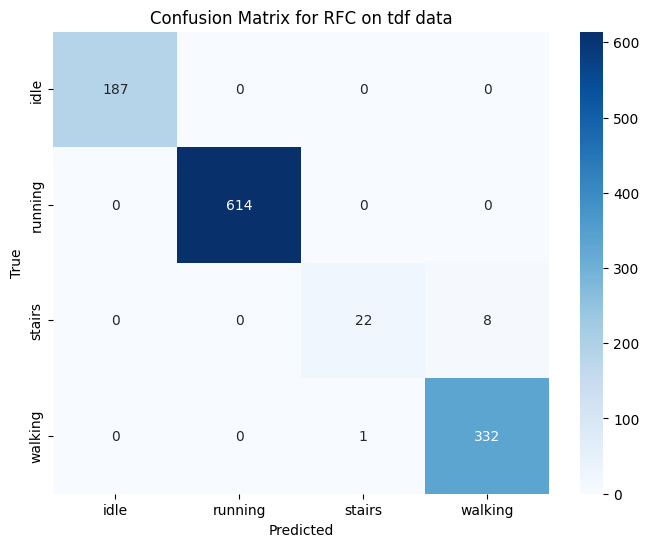

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       187
     running       1.00      1.00      1.00       614
      stairs       0.96      0.73      0.83        30
     walking       0.98      1.00      0.99       333

    accuracy                           0.99      1164
   macro avg       0.98      0.93      0.95      1164
weighted avg       0.99      0.99      0.99      1164



In [62]:
rfc_confusion_matrix = confusion_matrix(y_test, y_test_predicted_rfc)
rfc_classification_report = classification_report(y_test, y_test_predicted_rfc)
heatmap_plot("RFC on tdf data", rfc_confusion_matrix)
print(rfc_classification_report)